In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load: Load banglore home prices into a dataframe 

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
df1.shape

(13320, 9)

In [5]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df1["area_type"].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [7]:
df1["area_type"].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

### Drop features that are not required to build our model 

In [8]:
df2 = df1.drop(["area_type","society","balcony","availability"], axis = "columns")
df2.shape

(13320, 5)

## Data Cleaning: Handle NA values 

In [9]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df3.shape

(13246, 5)

## Feature Engineering 

### Add new feature(integer) for bhk (Bedrooms Hall Kitchen) 

In [12]:
df3["bhk"] = df3["size"].apply(lambda x: int(x.split(" ")[0]))
df3.bhk.unique()

<ipython-input-12-a48830d1d47c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["bhk"] = df3["size"].apply(lambda x: int(x.split(" ")[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

### Explore total_sqft feature 

In [13]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
def is_float(x) :
    try :
        float(x)
    except :
        return False
    return True

In [15]:
df3[~df3["total_sqft"].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


#### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [16]:
def convert_sqft_to_num(x) :
    tokens = x.split("-")
    if len(tokens) == 2 :
        return (float(tokens[0]) + float(tokens[1])) / 2
    try :
        return float(x)
    except :
        return None

In [17]:
df4 = df3.copy()

In [18]:
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]

In [19]:
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


## Feature Engineering 

### Add new feature called price per square feet

In [20]:
df5 = df4.copy()
df5["price_per_sqft"] = df5["price"]*100000/df5["total_sqft"]
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
df5_stats = df5["price_per_sqft"].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [22]:
df5.to_csv("bhp.csv",index = False)

### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [23]:
txt = "     banana     "

x = txt.strip()

print("of all fruits", x, "is my favorite")

of all fruits banana is my favorite


In [24]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5["location"].value_counts(ascending = False)
location_stats

Whitefield                         533
Sarjapur  Road                     392
Electronic City                    304
Kanakpura Road                     264
Thanisandra                        235
                                  ... 
Geetanjali Layout                    1
Bull Temple Road                     1
Kanakadasa Layout                    1
Nagarbhavi Garden Villas Layout      1
Pattegarhpalya                       1
Name: location, Length: 1287, dtype: int64

In [25]:
location_stats.values.sum()

13200

In [26]:
len(location_stats[location_stats>10])

240

In [27]:
len(location_stats)

1287

In [28]:
len(location_stats[location_stats<=10])

1047

## Dimensionality Reduction 

### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [29]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Dairy Circle                       10
BTM 1st Stage                      10
Kalkere                            10
1st Block Koramangala              10
Thyagaraja Nagar                   10
                                   ..
Geetanjali Layout                   1
Bull Temple Road                    1
Kanakadasa Layout                   1
Nagarbhavi Garden Villas Layout     1
Pattegarhpalya                      1
Name: location, Length: 1047, dtype: int64

In [30]:
len(df5.location.unique())

1287

In [31]:
df5.location = df5.location.apply(lambda x: "other" if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [32]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal Using Business Logic 

### As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft 

In [33]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely 

In [34]:
df5.shape

(13200, 7)

In [35]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]

## Outlier Removal Using Standard Deviation and Mean 

In [36]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

#### Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [37]:
df6.head(9)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275


In [38]:
df6.groupby("location").max()

,size,total_sqft,bath,price,bhk,price_per_sqft
location,,,,,,
1st Block Jayanagar,4 Bedroom,2850.0,4.0,450.0,4,18750.000000
1st Phase JP Nagar,5 Bedroom,4550.0,7.0,400.0,5,25000.000000
2nd Phase Judicial Layout,3 BHK,1681.0,3.0,69.0,3,5000.000000
2nd Stage Nagarbhavi,6 Bedroom,4000.0,8.0,451.0,6,20416.666667
5th Block Hbr Layout,6 BHK,5100.0,5.0,300.0,6,17083.333333
...,...,...,...,...,...,...
Yelahanka,6 Bedroom,35000.0,6.0,800.0,6,19875.776398
Yelahanka New Town,4 Bedroom,4000.0,3.0,899.0,4,22475.000000
Yelenahalli,3 BHK,1650.0,3.0,68.0,3,5176.876618


In [39]:
for key, subdf in df6.groupby("location") :
    print(key,subdf)

1st Block Jayanagar                   location       size  total_sqft  bath  price  bhk  \
210    1st Block Jayanagar      4 BHK      2850.0   4.0  428.0    4   
848    1st Block Jayanagar      3 BHK      1630.0   3.0  194.0    3   
2152   1st Block Jayanagar      3 BHK      1875.0   2.0  235.0    3   
2355   1st Block Jayanagar  4 Bedroom      2400.0   4.0  450.0    4   
4991   1st Block Jayanagar      2 BHK      1000.0   3.0   60.0    2   
7138   1st Block Jayanagar      3 BHK      1200.0   2.0  130.0    3   
7358   1st Block Jayanagar      2 BHK      1235.0   2.0  148.0    2   
7383   1st Block Jayanagar      4 BHK      2750.0   4.0  413.0    4   
8507   1st Block Jayanagar      3 BHK      1760.0   3.0  115.0    3   
10972  1st Block Jayanagar      4 BHK      2450.0   4.0  368.0    4   

       price_per_sqft  
210      15017.543860  
848      11901.840491  
2152     12533.333333  
2355     18750.000000  
4991      6000.000000  
7138     10833.333333  
7358     11983.805668  
7383  

12795  Basavangudi      3 BHK     1650.00   3.0  125.0    3     7575.757576
Basaveshwara Nagar                  location       size  total_sqft  bath  price  bhk  \
345    Basaveshwara Nagar      2 BHK      1200.0   2.0   65.0    2   
889    Basaveshwara Nagar  5 Bedroom      4500.0   5.0  415.0    5   
1140   Basaveshwara Nagar      3 BHK      1865.0   3.0  145.0    3   
1995   Basaveshwara Nagar  7 Bedroom      2460.0   7.0  350.0    7   
2441   Basaveshwara Nagar  5 Bedroom      2400.0   5.0  415.0    5   
3335   Basaveshwara Nagar      2 BHK      1200.0   2.0   90.0    2   
5693   Basaveshwara Nagar      2 BHK      1180.0   2.0   58.0    2   
6488   Basaveshwara Nagar  5 Bedroom      2400.0   4.0  310.0    5   
6616   Basaveshwara Nagar      2 BHK      1200.0   2.0   80.0    2   
9029   Basaveshwara Nagar      2 BHK       900.0   2.0   60.0    2   
9253   Basaveshwara Nagar  5 Bedroom      2520.0   4.0  378.0    5   
9274   Basaveshwara Nagar      3 BHK      1900.0   3.0  150.0    

Electronics City Phase 1                        location   size  total_sqft  bath   price  bhk  \
36     Electronics City Phase 1  2 BHK     1070.00   2.0   45.50    2   
213    Electronics City Phase 1  3 BHK     1475.00   3.0   78.29    3   
283    Electronics City Phase 1  3 BHK     1490.00   3.0   78.80    3   
393    Electronics City Phase 1  2 BHK     1113.27   2.0   53.00    2   
565    Electronics City Phase 1  3 BHK     1490.00   3.0   84.00    3   
...                         ...    ...         ...   ...     ...  ...   
12848  Electronics City Phase 1  3 BHK     1900.00   3.0   85.00    3   
12877  Electronics City Phase 1  2 BHK     1305.00   2.0   67.00    2   
12893  Electronics City Phase 1  1 BHK      755.00   1.0   30.12    1   
13106  Electronics City Phase 1  2 BHK     1175.00   2.0   60.00    2   
13188  Electronics City Phase 1  3 BHK     1700.00   3.0  111.00    3   

       price_per_sqft  
36        4252.336449  
213       5307.796610  
283       5288.590604  
39

13082   Jigani      2 BHK       943.0   2.0   49.5    2     5249.204666
Judicial Layout               location       size  total_sqft  bath   price  bhk  \
1403   Judicial Layout      3 BHK      1300.0   3.0   64.00    3   
1659   Judicial Layout      3 BHK      2070.0   3.0  162.00    3   
3703   Judicial Layout  3 Bedroom      1700.0   3.0  155.00    3   
6062   Judicial Layout      3 BHK      1100.0   2.0   53.00    3   
8046   Judicial Layout      4 BHK      2330.0   3.0   94.71    4   
9611   Judicial Layout  3 Bedroom      1200.0   4.0  220.00    3   
9626   Judicial Layout      2 BHK      1165.0   2.0   49.61    2   
9703   Judicial Layout  5 Bedroom      5400.0   4.0  700.00    5   
9883   Judicial Layout  4 Bedroom      2400.0   4.0  350.00    4   
10835  Judicial Layout  4 Bedroom      1500.0   3.0  162.00    4   
11164  Judicial Layout      2 BHK       900.0   2.0   40.00    2   
12808  Judicial Layout      3 BHK      1989.0   4.0  155.00    3   

       price_per_sqft  
140

Lakshminarayana Pura                    location   size  total_sqft  bath  price  bhk  \
53     Lakshminarayana Pura  2 BHK      1185.0   2.0   75.0    2   
375    Lakshminarayana Pura  3 BHK      1600.0   2.0  108.0    3   
934    Lakshminarayana Pura  3 BHK      1680.0   3.0  150.0    3   
1251   Lakshminarayana Pura  2 BHK      1180.0   2.0   75.0    2   
1991   Lakshminarayana Pura  2 BHK      1172.0   2.0   82.0    2   
2137   Lakshminarayana Pura  3 BHK      1750.0   3.0  150.0    3   
2233   Lakshminarayana Pura  2 BHK      1179.0   2.0   75.0    2   
3093   Lakshminarayana Pura  2 BHK      1149.0   2.0   75.0    2   
3434   Lakshminarayana Pura  2 BHK      1336.0   2.0  100.0    2   
3779   Lakshminarayana Pura  2 BHK      1175.0   2.0   75.0    2   
3816   Lakshminarayana Pura  2 BHK      1190.0   2.0   75.0    2   
4147   Lakshminarayana Pura  2 BHK      1200.0   2.0   75.0    2   
4158   Lakshminarayana Pura  2 BHK      1200.0   2.0   75.0    2   
4518   Lakshminarayana Pura

11733  Prithvi Layout      4 BHK      4040.0   4.0  500.0    4    12376.237624
R.T. Nagar          location       size  total_sqft  bath  price  bhk  price_per_sqft
617    R.T. Nagar  4 Bedroom      1500.0   4.0   70.0    4     4666.666667
1714   R.T. Nagar  2 Bedroom      1200.0   2.0  120.0    2    10000.000000
2052   R.T. Nagar      3 BHK      1560.0   3.0   85.0    3     5448.717949
2342   R.T. Nagar      2 BHK      1040.0   2.0   46.0    2     4423.076923
3502   R.T. Nagar      2 BHK      1200.0   2.0   45.0    2     3750.000000
4045   R.T. Nagar  4 Bedroom      2000.0   4.0  320.0    4    16000.000000
4746   R.T. Nagar      2 BHK      1235.0   2.0   65.0    2     5263.157895
4855   R.T. Nagar  2 Bedroom       800.0   1.0  170.0    2    21250.000000
4941   R.T. Nagar  5 Bedroom      2400.0   6.0  450.0    5    18750.000000
5152   R.T. Nagar  3 Bedroom      1140.0   3.0  130.0    3    11403.508772
5675   R.T. Nagar      2 BHK       970.0   2.0   55.0    2     5670.103093
6072   R.T

10371  Varthur Road      2 BHK       850.0   2.0   25.40    2     2988.235294
Vasanthapura            location   size  total_sqft  bath  price  bhk  price_per_sqft
626    Vasanthapura  3 BHK      1400.0   3.0  60.00    3     4285.714286
834    Vasanthapura  2 BHK      1022.0   2.0  40.00    2     3913.894325
1070   Vasanthapura  2 BHK      1135.0   2.0  39.73    2     3500.440529
3750   Vasanthapura  2 BHK       995.0   2.0  34.82    2     3499.497487
6499   Vasanthapura  2 BHK       995.0   2.0  34.82    2     3499.497487
7292   Vasanthapura  2 BHK      1050.0   2.0  47.00    2     4476.190476
8848   Vasanthapura  2 BHK       940.0   2.0  40.00    2     4255.319149
9422   Vasanthapura  2 BHK      1500.0   2.0  65.00    2     4333.333333
9532   Vasanthapura  2 BHK      1037.0   2.0  36.28    2     3498.553520
9945   Vasanthapura  2 BHK       978.0   2.0  34.22    2     3498.977505
10976  Vasanthapura  2 BHK      1037.0   2.0  36.28    2     3498.553520
Vidyaranyapura              locat

In [40]:
def remove_pps_outliers(df) :
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location") :
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

In [41]:
df7.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

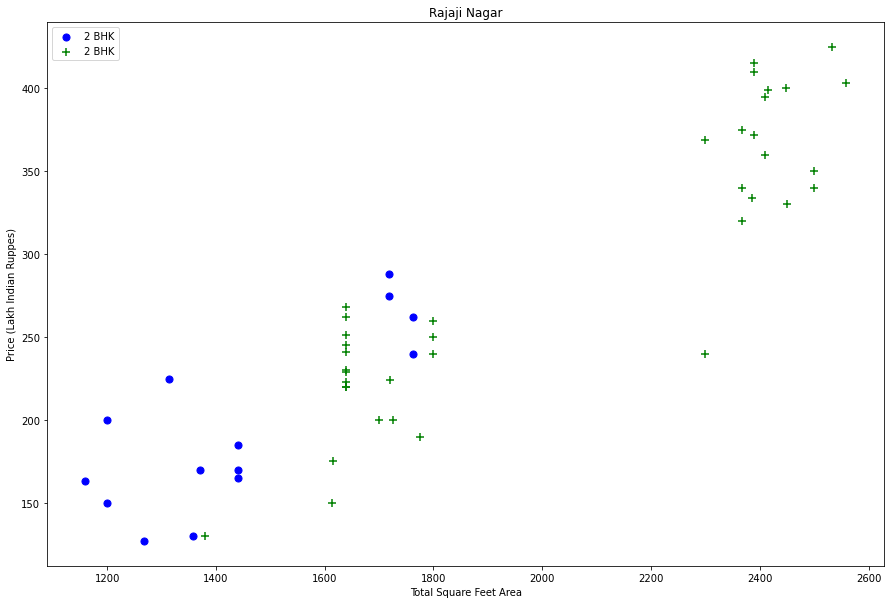

In [42]:
def plot_scatter_chart(df,location) :
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams["figure.figsize"] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = "blue", label = "2 BHK", s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker = "+", color = "green", label = "2 BHK", s = 50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Ruppes)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7, "Rajaji Nagar")

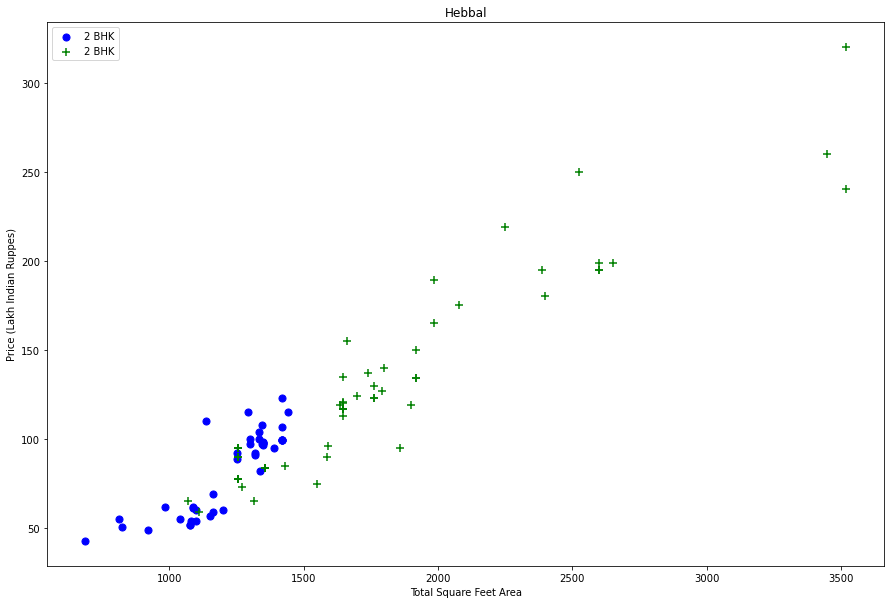

In [43]:
plot_scatter_chart(df7,"Hebbal")

### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e. 

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}

###  Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [44]:
df7.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
5,1st Block Jayanagar,4 BHK,2750.0,4.0,413.0,4,15018.181818
6,1st Block Jayanagar,4 BHK,2450.0,4.0,368.0,4,15020.408163
7,1st Phase JP Nagar,4 BHK,2825.0,4.0,250.0,4,8849.557522
8,1st Phase JP Nagar,3 BHK,1875.0,3.0,167.0,3,8906.666667
9,1st Phase JP Nagar,5 Bedroom,1500.0,5.0,85.0,5,5666.666667


In [45]:
for location, location_df in df7.groupby("location") :
    for bhk, bhk_df in location_df.groupby("bhk") :
        print(bhk)
        print(bhk_df)

2
              location   size  total_sqft  bath  price  bhk  price_per_sqft
4  1st Block Jayanagar  2 BHK      1235.0   2.0  148.0    2    11983.805668
3
              location   size  total_sqft  bath  price  bhk  price_per_sqft
1  1st Block Jayanagar  3 BHK      1630.0   3.0  194.0    3    11901.840491
2  1st Block Jayanagar  3 BHK      1875.0   2.0  235.0    3    12533.333333
3  1st Block Jayanagar  3 BHK      1200.0   2.0  130.0    3    10833.333333
4
              location   size  total_sqft  bath  price  bhk  price_per_sqft
0  1st Block Jayanagar  4 BHK      2850.0   4.0  428.0    4    15017.543860
5  1st Block Jayanagar  4 BHK      2750.0   4.0  413.0    4    15018.181818
6  1st Block Jayanagar  4 BHK      2450.0   4.0  368.0    4    15020.408163
1
              location   size  total_sqft  bath  price  bhk  price_per_sqft
16  1st Phase JP Nagar  1 BHK       840.0   2.0   50.0    1     5952.380952
2
              location       size  total_sqft  bath  price  bhk  \
13  1st Pha

1
         location   size  total_sqft  bath  price  bhk  price_per_sqft
431  Ananth Nagar  1 BHK       500.0   1.0   14.0    1          2800.0
434  Ananth Nagar  1 BHK       500.0   2.0   14.0    1          2800.0
440  Ananth Nagar  1 BHK       500.0   1.0   14.0    1          2800.0
454  Ananth Nagar  1 BHK       500.0   1.0   14.0    1          2800.0
2
         location   size  total_sqft  bath  price  bhk  price_per_sqft
432  Ananth Nagar  2 BHK      1100.0   2.0  31.50    2     2863.636364
433  Ananth Nagar  2 BHK       982.0   2.0  24.55    2     2500.000000
435  Ananth Nagar  2 BHK       900.0   2.0  22.50    2     2500.000000
436  Ananth Nagar  2 BHK       908.0   2.0  26.00    2     2863.436123
437  Ananth Nagar  2 BHK       870.0   2.0  36.00    2     4137.931034
438  Ananth Nagar  2 BHK       937.0   2.0  35.00    2     3735.325507
439  Ananth Nagar  2 BHK       960.0   2.0  37.00    2     3854.166667
441  Ananth Nagar  2 BHK      1000.0   2.0  29.70    2     2970.000000
44

785  Banashankari Stage V  2 BHK       920.0   2.0  41.50    2     4510.869565
3
                 location   size  total_sqft  bath  price  bhk  price_per_sqft
775  Banashankari Stage V  3 BHK      1300.0   2.0  58.50    3     4500.000000
776  Banashankari Stage V  3 BHK      1305.0   2.0  49.00    3     3754.789272
778  Banashankari Stage V  3 BHK      1355.0   2.0  61.00    3     4501.845018
779  Banashankari Stage V  3 BHK      1510.0   3.0  47.57    3     3150.331126
780  Banashankari Stage V  3 BHK      1650.0   3.0  51.98    3     3150.303030
781  Banashankari Stage V  3 BHK      1630.0   3.0  51.35    3     3150.306748
782  Banashankari Stage V  3 BHK      1510.0   3.0  47.57    3     3150.331126
783  Banashankari Stage V  3 BHK      1315.0   2.0  49.00    3     3726.235741
784  Banashankari Stage V  3 BHK      1540.0   3.0  48.51    3     3150.000000
2
                  location   size  total_sqft  bath   price  bhk  \
786  Banashankari Stage VI  2 BHK      1177.5   2.0  59.935

1241  Billekahalli      3 BHK      1805.0   3.0  134.0    3     7423.822715
1
        location   size  total_sqft  bath  price  bhk  price_per_sqft
1243  Binny Pete  1 BHK       665.0   1.0  50.75    1     7631.578947
1245  Binny Pete  1 BHK       660.0   1.0  54.00    1     8181.818182
1246  Binny Pete  1 BHK       660.0   1.0  62.00    1     9393.939394
2
        location   size  total_sqft  bath  price  bhk  price_per_sqft
1247  Binny Pete  2 BHK      1365.0   2.0  122.0    2     8937.728938
3
        location   size  total_sqft  bath  price  bhk  price_per_sqft
1242  Binny Pete  3 BHK      1755.0   3.0  122.0    3     6951.566952
1244  Binny Pete  3 BHK      2465.0   5.0  234.0    3     9492.900609
1249  Binny Pete  3 BHK      1795.0   3.0  139.0    3     7743.732591
1250  Binny Pete  3 BHK      1740.0   3.0  150.0    3     8620.689655
1251  Binny Pete  3 BHK      1970.0   3.0  164.0    3     8324.873096
1252  Binny Pete  3 BHK      1516.0   3.0  147.0    3     9696.569921
4
      

1659  Chikkalasandra  3 BHK      1425.0   1.0  54.00    3     3789.473684
2
          location   size  total_sqft  bath  price  bhk  price_per_sqft
1660  Choodasandra  2 BHK      1115.0   2.0  50.00    2     4484.304933
1661  Choodasandra  2 BHK      1300.0   2.0  57.00    2     4384.615385
1665  Choodasandra  2 BHK      1197.0   2.0  63.00    2     5263.157895
1667  Choodasandra  2 BHK      1115.0   2.0  50.00    2     4484.304933
1668  Choodasandra  2 BHK      1215.0   2.0  59.00    2     4855.967078
1671  Choodasandra  2 BHK       725.0   2.0  36.00    2     4965.517241
1674  Choodasandra  2 BHK      1075.0   2.0  45.00    2     4186.046512
1675  Choodasandra  2 BHK      1180.0   2.0  71.22    2     6035.593220
1676  Choodasandra  2 BHK      1140.0   2.0  62.00    2     5438.596491
1679  Choodasandra  2 BHK      1065.0   2.0  46.00    2     4319.248826
1680  Choodasandra  2 BHK      1115.0   2.0  50.00    2     4484.304933
1682  Choodasandra  2 BHK      1115.0   2.0  50.00    2     

2382  GM Palaya  2 BHK      1140.0   2.0  48.95    2     4293.859649
3
       location   size  total_sqft  bath  price  bhk  price_per_sqft
2380  GM Palaya  3 BHK      1820.0   2.0   86.0    3     4725.274725
2383  GM Palaya  3 BHK      1315.0   2.0   65.0    3     4942.965779
2384  GM Palaya  3 BHK      1315.0   3.0   65.0    3     4942.965779
2385  GM Palaya  3 BHK      1315.0   3.0   64.0    3     4866.920152
2386  GM Palaya  3 BHK      1735.0   3.0   70.0    3     4034.582133
2387  GM Palaya  3 BHK      1643.0   2.0   70.0    3     4260.499087
2
              location   size  total_sqft  bath  price  bhk  price_per_sqft
2389  Garudachar Palya  2 BHK      1060.0   2.0  48.70    2     4594.339623
2390  Garudachar Palya  2 BHK      1150.0   2.0  52.75    2     4586.956522
2394  Garudachar Palya  2 BHK      1150.0   2.0  52.80    2     4591.304348
2395  Garudachar Palya  2 BHK      1150.0   2.0  52.80    2     4591.304348
2396  Garudachar Palya  2 BHK      1060.0   2.0  48.50    2     

3155  Hennur Road  2 BHK      1155.0   2.0   69.18    2     5989.610390
3
         location       size  total_sqft  bath  price  bhk  price_per_sqft
3027  Hennur Road      3 BHK      2089.0   3.0  140.0    3     6701.771182
3031  Hennur Road      3 BHK      1500.0   2.0   62.0    3     4133.333333
3032  Hennur Road  3 Bedroom      2264.0   3.0  159.0    3     7022.968198
3034  Hennur Road      3 BHK      1904.0   3.0  120.0    3     6302.521008
3035  Hennur Road      3 BHK      1891.0   3.0  109.0    3     5764.145955
...           ...        ...         ...   ...    ...  ...             ...
3143  Hennur Road      3 BHK      1672.0   3.0   86.0    3     5143.540670
3150  Hennur Road      3 BHK      1891.0   3.0  110.0    3     5817.028027
3151  Hennur Road      3 BHK      1735.0   3.0   78.0    3     4495.677233
3152  Hennur Road      3 BHK      1470.0   2.0   75.0    3     5102.040816
3156  Hennur Road      3 BHK      1936.0   3.0  131.0    3     6766.528926

[70 rows x 7 columns]
4
 

3517  Indira Nagar  8 Bedroom      3250.0   8.0  600.0    8    18461.538462
1
      location   size  total_sqft  bath  price  bhk  price_per_sqft
3546  JP Nagar  1 BHK      1050.0   1.0  44.00    1      4190.47619
3556  JP Nagar  1 BHK       750.0   1.0  52.50    1      7000.00000
3569  JP Nagar  1 BHK       745.0   1.0  34.27    1      4600.00000
2
      location   size  total_sqft  bath   price  bhk  price_per_sqft
3540  JP Nagar  2 BHK      1000.0   2.0  35.000    2     3500.000000
3541  JP Nagar  2 BHK      1100.0   2.0  70.000    2     6363.636364
3542  JP Nagar  2 BHK       940.0   2.0  49.000    2     5212.765957
3545  JP Nagar  2 BHK      1078.0   2.0  45.000    2     4174.397032
3547  JP Nagar  2 BHK      1352.5   2.0  93.865    2     6940.110906
3548  JP Nagar  2 BHK      1200.0   2.0  62.000    2     5166.666667
3549  JP Nagar  2 BHK      1300.0   2.0  90.870    2     6990.000000
3557  JP Nagar  2 BHK      1200.0   2.0  78.000    2     6500.000000
3559  JP Nagar  2 BHK      

3934  Kalena Agrahara  3 BHK      1510.0   3.0   78.0    3     5165.562914
2
          location   size  total_sqft  bath  price  bhk  price_per_sqft
3939  Kalyan nagar  2 BHK       820.0   2.0   39.0    2     4756.097561
3943  Kalyan nagar  2 BHK      1080.0   2.0   73.0    2     6759.259259
3945  Kalyan nagar  2 BHK      1280.0   2.0   48.0    2     3750.000000
3947  Kalyan nagar  2 BHK      1198.0   2.0   65.0    2     5425.709516
3948  Kalyan nagar  2 BHK      1250.0   2.0   65.0    2     5200.000000
3949  Kalyan nagar  2 BHK      1190.0   2.0   60.0    2     5042.016807
3950  Kalyan nagar  2 BHK      1086.0   2.0   44.5    2     4097.605893
3952  Kalyan nagar  2 BHK      1100.0   2.0   70.0    2     6363.636364
3
          location   size  total_sqft  bath  price  bhk  price_per_sqft
3938  Kalyan nagar  3 BHK      1375.0   3.0   75.0    3     5454.545455
3941  Kalyan nagar  3 BHK      1640.0   3.0   88.0    3     5365.853659
3942  Kalyan nagar  3 BHK      1800.0   3.0   85.0    3  

4406  Kengeri      3 BHK      1245.0   2.0  43.57    3     3499.598394
5
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4420  Kengeri  5 Bedroom      2500.0   4.0  100.0    5          4000.0
8
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4415  Kengeri  8 Bedroom      3000.0   5.0  130.0    8     4333.333333
1
                    location   size  total_sqft  bath  price  bhk  \
4425  Kengeri Satellite Town  1 BHK       930.0   1.0   30.0    1   
4436  Kengeri Satellite Town  1 BHK       654.0   1.0   22.0    1   
4441  Kengeri Satellite Town  1 BHK       410.0   1.0   15.0    1   

      price_per_sqft  
4425     3225.806452  
4436     3363.914373  
4441     3658.536585  
2
                    location       size  total_sqft  bath   price  bhk  \
4422  Kengeri Satellite Town      2 BHK       890.0   2.0  35.000    2   
4423  Kengeri Satellite Town      2 BHK       883.0   2.0  45.000    2   
4427  Kengeri Satellite Town      2 BHK      1

4779  LB Shastri Nagar  3 BHK      1400.0   2.0   80.0    3     5714.285714
1
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4786  Laggere  1 Bedroom      1200.0   1.0  125.0    1    10416.666667
4788  Laggere  1 Bedroom       620.0   2.0   48.0    1     7741.935484
2
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4787  Laggere  2 Bedroom      1200.0   2.0   75.0    2          6250.0
3
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4785  Laggere  3 Bedroom      1200.0   3.0  130.0    3    10833.333333
5
     location       size  total_sqft  bath  price  bhk  price_per_sqft
4784  Laggere  5 Bedroom      2800.0   5.0  125.0    5     4464.285714
2
                  location   size  total_sqft  bath  price  bhk  \
4789  Lakshminarayana Pura  2 BHK      1185.0   2.0   75.0    2   
4791  Lakshminarayana Pura  2 BHK      1180.0   2.0   75.0    2   
4792  Lakshminarayana Pura  2 BHK      1172.0   2.0   82.0    2   
4793  L

5235  Nagarbhavi      2 BHK      1225.0   2.0   58.0    2     4734.693878
3
        location       size  total_sqft  bath  price  bhk  price_per_sqft
5197  Nagarbhavi      3 BHK      1630.0   2.0   98.0    3     6012.269939
5198  Nagarbhavi  3 Bedroom      1350.0   3.0  150.0    3    11111.111111
5200  Nagarbhavi      3 BHK      1523.0   2.0   53.4    3     3506.237689
5201  Nagarbhavi  3 Bedroom      2400.0   3.0  160.0    3     6666.666667
5204  Nagarbhavi      3 BHK      1350.0   2.0   54.6    3     4044.444444
5207  Nagarbhavi      3 BHK      1560.0   3.0   66.0    3     4230.769231
5209  Nagarbhavi      3 BHK      1400.0   2.0   85.0    3     6071.428571
5210  Nagarbhavi      3 BHK      1515.0   2.0   79.0    3     5214.521452
5215  Nagarbhavi      3 BHK      1850.0   3.0   88.0    3     4756.756757
5218  Nagarbhavi      3 BHK      1850.0   3.0   90.0    3     4864.864865
5220  Nagarbhavi      3 BHK      1850.0   2.0   88.0    3     4756.756757
5222  Nagarbhavi      3 BHK      185

4
          location   size  total_sqft  bath  price  bhk  price_per_sqft
5533  Rachenahalli  4 BHK      3657.0   5.0  220.0    4     6015.859995
1
                   location   size  total_sqft  bath  price  bhk  \
5573  Raja Rajeshwari Nagar  1 BHK       600.0   1.0  22.00    1   
5575  Raja Rajeshwari Nagar  1 BHK       500.0   1.0  25.00    1   
5603  Raja Rajeshwari Nagar  1 BHK       648.0   1.0  31.75    1   
5614  Raja Rajeshwari Nagar  1 BHK       550.0   1.0  21.00    1   
5722  Raja Rajeshwari Nagar  1 BHK       510.0   1.0  22.00    1   

      price_per_sqft  
5573     3666.666667  
5575     5000.000000  
5603     4899.691358  
5614     3818.181818  
5722     4313.725490  
2
                   location   size  total_sqft  bath  price  bhk  \
5563  Raja Rajeshwari Nagar  2 BHK      1295.0   2.0  43.90    2   
5564  Raja Rajeshwari Nagar  2 BHK      1145.0   2.0  45.79    2   
5565  Raja Rajeshwari Nagar  2 BHK      1419.0   2.0  48.10    2   
5566  Raja Rajeshwari Nagar  2 

6360     9166.666667  
2
        location       size  total_sqft  bath  price  bhk  price_per_sqft
6371  Seegehalli      2 BHK       901.0   2.0  35.14    2     3900.110988
6373  Seegehalli  2 Bedroom       800.0   1.0  50.00    2     6250.000000
6375  Seegehalli      2 BHK      1118.0   2.0  37.50    2     3354.203936
6377  Seegehalli  2 Bedroom      1155.0   2.0  72.00    2     6233.766234
6382  Seegehalli      2 BHK      1096.0   2.0  41.00    2     3740.875912
6384  Seegehalli      2 BHK       920.0   2.0  27.00    2     2934.782609
6388  Seegehalli      2 BHK      1134.0   2.0  45.00    2     3968.253968
6390  Seegehalli      2 BHK      1176.0   2.0  50.00    2     4251.700680
3
        location       size  total_sqft  bath  price  bhk  price_per_sqft
6372  Seegehalli      3 BHK      1150.0   2.0   42.9    3     3730.434783
6374  Seegehalli      3 BHK      1525.0   3.0   65.0    3     4262.295082
6376  Seegehalli  3 Bedroom      1200.0   2.0   62.0    3     5166.666667
6378  Seege

[75 rows x 7 columns]
3
         location   size  total_sqft  bath  price  bhk  price_per_sqft
6831  Uttarahalli  3 BHK      1440.0   2.0  62.00    3     4305.555556
6837  Uttarahalli  3 BHK      1135.0   2.0  39.73    3     3500.440529
6838  Uttarahalli  3 BHK      1540.0   3.0  50.00    3     3246.753247
6840  Uttarahalli  3 BHK      1390.0   2.0  62.55    3     4500.000000
6841  Uttarahalli  3 BHK      1330.0   2.0  56.00    3     4210.526316
...           ...    ...         ...   ...    ...  ...             ...
6991  Uttarahalli  3 BHK      1290.0   2.0  56.12    3     4350.387597
6992  Uttarahalli  3 BHK      1328.0   2.0  56.00    3     4216.867470
6994  Uttarahalli  3 BHK      1290.0   2.0  56.12    3     4350.387597
6995  Uttarahalli  3 BHK      1590.0   3.0  57.00    3     3584.905660
6997  Uttarahalli  3 BHK      1345.0   2.0  57.00    3     4237.918216

[89 rows x 7 columns]
4
         location       size  total_sqft  bath  price  bhk  price_per_sqft
6970  Uttarahalli  4 Bed

7935  Yeshwanthpur  3 BHK      1675.0   3.0   92.13    3     5500.298507
4
          location   size  total_sqft  bath  price  bhk  price_per_sqft
7869  Yeshwanthpur  4 BHK      1950.0   4.0  130.0    4     6666.666667
7886  Yeshwanthpur  4 BHK      3600.0   5.0  220.0    4     6111.111111
6
          location       size  total_sqft  bath  price  bhk  price_per_sqft
7928  Yeshwanthpur  6 Bedroom      2500.0   5.0  185.0    6          7400.0
1
      location       size  total_sqft  bath  price  bhk  price_per_sqft
7939     other      1 BHK       600.0   1.0   38.0    1     6333.333333
8036     other  1 Bedroom       700.0   1.0   41.0    1     5857.142857
8040     other      1 BHK      1200.0   2.0   85.0    1     7083.333333
8051     other  1 Bedroom       540.0   1.0   36.0    1     6666.666667
8055     other      1 BHK       416.0   1.0   18.5    1     4447.115385
...        ...        ...         ...   ...    ...  ...             ...
10177    other      1 BHK       450.0   1.0   20.

In [46]:
for location, location_df in df7.groupby("location") :
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby("bhk") :
        bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df.price_per_sqft),
                "std" : np.std(bhk_df.price_per_sqft),
                "count" : bhk_df.shape[0]
            }
        print(bhk_stats[bhk])
    

{'mean': 11983.805668016194, 'std': 0.0, 'count': 1}
{'mean': 11756.16905248807, 'std': 701.6243657657865, 'count': 3}
{'mean': 15018.711280365416, 'std': 1.2278182423353805, 'count': 3}
{'mean': 5952.380952380952, 'std': 0.0, 'count': 1}
{'mean': 7931.806799837383, 'std': 1534.1422783514054, 'count': 8}
{'mean': 9151.192151725822, 'std': 1054.731726021645, 'count': 7}
{'mean': 7537.92218148637, 'std': 1607.0591069513537, 'count': 3}
{'mean': 5666.666666666667, 'std': 0.0, 'count': 1}
{'mean': 3851.8518518518517, 'std': 497.593660834978, 'count': 3}
{'mean': 3620.93991671624, 'std': 241.87983343248052, 'count': 5}
{'mean': 15891.203703703704, 'std': 1668.9846920398563, 'count': 4}
{'mean': 16891.666666666668, 'std': 1858.333333333333, 'count': 2}
{'mean': 4755.410708222867, 'std': 374.06419031565235, 'count': 3}
{'mean': 5511.811023622047, 'std': 0.0, 'count': 1}
{'mean': 3611.1111111111113, 'std': 0.0, 'count': 1}
{'mean': 5882.35294117647, 'std': 0.0, 'count': 1}
{'mean': 4628.623188

{'mean': 4302.184466019417, 'std': 552.1844660194174, 'count': 2}
{'mean': 4445.805384477064, 'std': 526.9310898804862, 'count': 8}
{'mean': 4254.328104328105, 'std': 505.922183603648, 'count': 4}
{'mean': 4047.6190476190477, 'std': 0.0, 'count': 1}
{'mean': 4666.666666666667, 'std': 0.0, 'count': 1}
{'mean': 3813.947572153106, 'std': 244.23665886444502, 'count': 19}
{'mean': 3815.8530659565145, 'std': 403.8116627539011, 'count': 11}
{'mean': 2887.892987573868, 'std': 0.47920744469383775, 'count': 11}
{'mean': 2863.160206574431, 'std': 59.9654742104211, 'count': 7}
{'mean': 8565.382032363164, 'std': 1314.9620051314946, 'count': 3}
{'mean': 8564.836466843257, 'std': 717.6221010374835, 'count': 6}
{'mean': 5837.4926933902225, 'std': 903.6255944977522, 'count': 19}
{'mean': 5795.407173862258, 'std': 1201.0625471599164, 'count': 13}
{'mean': 6680.252598242926, 'std': 2089.3417875296827, 'count': 7}
{'mean': 8974.358974358975, 'std': 0.0, 'count': 1}
{'mean': 5155.722891566265, 'std': 166.4

{'mean': 5833.333333333333, 'std': 0.0, 'count': 1}
{'mean': 6608.695652173913, 'std': 0.0, 'count': 1}
{'mean': 4442.431489020303, 'std': 902.0297287001697, 'count': 81}
{'mean': 5508.10108742305, 'std': 934.2074392416823, 'count': 39}
{'mean': 6117.534949943386, 'std': 823.7488337812644, 'count': 6}
{'mean': 6137.381184467408, 'std': 760.3945168588826, 'count': 31}
{'mean': 6733.500810366982, 'std': 1010.6906117602452, 'count': 34}
{'mean': 6806.220763959648, 'std': 749.5046631700119, 'count': 6}
{'mean': 6682.792074857584, 'std': 1166.867220004498, 'count': 43}
{'mean': 7043.160774820713, 'std': 1086.4743742344735, 'count': 63}
{'mean': 8020.904932434183, 'std': 883.2866989126516, 'count': 24}
{'mean': 8716.498778998779, 'std': 1081.9219617716674, 'count': 4}
{'mean': 9517.562179481964, 'std': 939.9188933583704, 'count': 13}
{'mean': 8861.240238842134, 'std': 978.6206485541776, 'count': 4}
{'mean': 8320.802005012532, 'std': 373.56532189325577, 'count': 3}
{'mean': 6157.975113248077,

{'mean': 5690.909090909091, 'std': 0.0, 'count': 1}
{'mean': 5584.57638412496, 'std': 830.9704121531988, 'count': 30}
{'mean': 5761.689498642713, 'std': 998.0178355092115, 'count': 32}
{'mean': 7188.150786398397, 'std': 888.4937505820675, 'count': 6}
{'mean': 6041.583372234744, 'std': 653.8682870762742, 'count': 6}
{'mean': 5916.740546308524, 'std': 721.5559950179522, 'count': 5}
{'mean': 6387.757738248516, 'std': 205.06926597089296, 'count': 2}
{'mean': 5500.0, 'std': 0.0, 'count': 1}
{'mean': 5791.147903867093, 'std': 283.9730475517742, 'count': 18}
{'mean': 5208.333333333333, 'std': 0.0, 'count': 1}
{'mean': 4651.883076314409, 'std': 642.90451560445, 'count': 13}
{'mean': 5264.778325123152, 'std': 92.36453201970426, 'count': 2}
{'mean': 5646.853146853147, 'std': 646.8531468531469, 'count': 2}
{'mean': 5274.4401769080805, 'std': 359.1996745553106, 'count': 7}
{'mean': 5460.627817637033, 'std': 264.58222613843435, 'count': 3}
{'mean': 4102.12346939793, 'std': 591.7443122845393, 'count

{'mean': 6417.676818637855, 'std': 641.5678764128289, 'count': 4}
{'mean': 5624.607559361702, 'std': 176.28469731669043, 'count': 4}
{'mean': 3750.8127802427566, 'std': 837.10794554603, 'count': 3}
{'mean': 3601.3181568393316, 'std': 896.300794280481, 'count': 5}
{'mean': 4446.286519616966, 'std': 851.8567154201359, 'count': 3}
{'mean': 4000.0, 'std': 0.0, 'count': 1}
{'mean': 4397.856538497696, 'std': 147.59800695684862, 'count': 2}
{'mean': 5323.390108322737, 'std': 476.8505751937556, 'count': 5}
{'mean': 4994.3116788028365, 'std': 83.97863012649077, 'count': 2}
{'mean': 6060.732226936822, 'std': 765.1028054888121, 'count': 8}
{'mean': 6395.974418965156, 'std': 1354.455921644706, 'count': 4}
{'mean': 8088.235294117647, 'std': 0.0, 'count': 1}
{'mean': 6488.103629335819, 'std': 666.8103212209145, 'count': 8}
{'mean': 7732.476289952065, 'std': 1345.392120110078, 'count': 3}
{'mean': 7400.652269436281, 'std': 366.6527535174725, 'count': 19}
{'mean': 5660.295741126656, 'std': 850.7558483

{'mean': 4331.910572925388, 'std': 847.3795043583863, 'count': 32}
{'mean': 4836.478103600665, 'std': 892.2656889001147, 'count': 14}
{'mean': 3754.9654055540996, 'std': 648.3927903937736, 'count': 7}
{'mean': 3800.411985861906, 'std': 850.7508048357686, 'count': 2}
{'mean': 3558.48776757308, 'std': 145.0953916099316, 'count': 7}
{'mean': 4639.399867778706, 'std': 870.5642061348253, 'count': 16}
{'mean': 5418.695502028836, 'std': 956.0813080374586, 'count': 6}
{'mean': 6562.5, 'std': 937.5, 'count': 2}
{'mean': 7513.33715688642, 'std': 1470.1647292081748, 'count': 4}
{'mean': 5936.626849748775, 'std': 879.0177188541079, 'count': 11}
{'mean': 6585.510613483119, 'std': 860.4381230168186, 'count': 17}
{'mean': 12000.0, 'std': 0.0, 'count': 1}
{'mean': 5208.333333333333, 'std': 0.0, 'count': 1}
{'mean': 4000.0, 'std': 0.0, 'count': 1}
{'mean': 4125.0, 'std': 375.0, 'count': 2}
{'mean': 4380.952380952381, 'std': 0.0, 'count': 1}
{'mean': 3916.9969520750556, 'std': 177.84130871379733, 'count

In [47]:
for location, location_df in df7.groupby("location") :
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby("bhk") :
        bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df.price_per_sqft),
                "std" : np.std(bhk_df.price_per_sqft),
                "count" : bhk_df.shape[0]
            }
    for bhk, bhk_df in location_df.groupby("bhk"):
        stats = bhk_stats.get(bhk - 1)
        print(stats)

None
{'mean': 11983.805668016194, 'std': 0.0, 'count': 1}
{'mean': 11756.16905248807, 'std': 701.6243657657865, 'count': 3}
None
{'mean': 5952.380952380952, 'std': 0.0, 'count': 1}
{'mean': 7931.806799837383, 'std': 1534.1422783514054, 'count': 8}
{'mean': 9151.192151725822, 'std': 1054.731726021645, 'count': 7}
{'mean': 7537.92218148637, 'std': 1607.0591069513537, 'count': 3}
None
{'mean': 3851.8518518518517, 'std': 497.593660834978, 'count': 3}
None
None
None
{'mean': 4755.410708222867, 'std': 374.06419031565235, 'count': 3}
None
{'mean': 3611.1111111111113, 'std': 0.0, 'count': 1}
None
{'mean': 4628.623188405797, 'std': 371.376811594203, 'count': 2}
{'mean': 5067.359785883266, 'std': 453.24956183513086, 'count': 17}
None
None
{'mean': 5932.976565810136, 'std': 671.9347030151997, 'count': 8}
{'mean': 8403.2863080867, 'std': 1515.4146231166221, 'count': 5}
None
{'mean': 6133.333333333334, 'std': 133.33333333333348, 'count': 2}
{'mean': 6272.516842644272, 'std': 1012.7881476778178, 'co

None
{'mean': 3902.439024390244, 'std': 0.0, 'count': 1}
{'mean': 4326.739586439992, 'std': 1082.6324000628515, 'count': 9}
None
{'mean': 4271.409551033765, 'std': 572.5384233681566, 'count': 19}
None
None
{'mean': 6861.368629625442, 'std': 792.385913681854, 'count': 3}
None
{'mean': 4009.260011822078, 'std': 22.428701187061954, 'count': 6}
None
{'mean': 3193.939393939394, 'std': 145.7068518808643, 'count': 3}
{'mean': 3695.715772231204, 'std': 513.1647769886983, 'count': 14}
None
{'mean': 9445.779914529914, 'std': 948.6331997307019, 'count': 3}
{'mean': 7329.742881854468, 'std': 773.8913545349003, 'count': 3}
None
{'mean': 3322.6608898241893, 'std': 544.174150775161, 'count': 8}
{'mean': 3313.5675560999007, 'std': 817.0930121375212, 'count': 3}
None
{'mean': 6352.512219589275, 'std': 547.9667498496266, 'count': 7}
{'mean': 6961.117262886345, 'std': 262.90361114936303, 'count': 8}
None
{'mean': 4328.254265940121, 'std': 1179.3241254681986, 'count': 20}
{'mean': 4223.573582626289, 'std'

None
{'mean': 8428.57142857143, 'std': 0.0, 'count': 1}
None
{'mean': 6896.551724137931, 'std': 0.0, 'count': 1}
None
{'mean': 2916.3934426229507, 'std': 116.39344262295072, 'count': 2}
{'mean': 3227.8474191127148, 'std': 607.9293263487696, 'count': 15}
None
{'mean': 5096.602546756389, 'std': 417.85606461579323, 'count': 5}
{'mean': 4604.465395835363, 'std': 480.2703857860582, 'count': 11}
{'mean': 4969.70888132023, 'std': 588.0621061875769, 'count': 10}
None
{'mean': 5119.046144238704, 'std': 440.4864827192896, 'count': 20}
{'mean': 5076.61097773778, 'std': 519.9588688689665, 'count': 71}
{'mean': 4882.675818502869, 'std': 566.9559827376457, 'count': 96}
None
{'mean': 5781.957506095438, 'std': 175.0239571773057, 'count': 6}
{'mean': 6165.072841663136, 'std': 431.9125650497451, 'count': 3}
None
{'mean': 6149.479659413434, 'std': 0.0, 'count': 1}
None
{'mean': 5690.909090909091, 'std': 0.0, 'count': 1}
{'mean': 5584.57638412496, 'std': 830.9704121531988, 'count': 30}
{'mean': 5761.68949

None
{'mean': 4074.074074074074, 'std': 0.0, 'count': 1}
{'mean': 5697.4094763372195, 'std': 619.4809937733468, 'count': 20}
{'mean': 5441.915480148754, 'std': 526.2209882855493, 'count': 25}
None
{'mean': 4580.285299806576, 'std': 455.35287836606403, 'count': 4}
None
{'mean': 5507.90053944953, 'std': 849.6957660583143, 'count': 23}
{'mean': 5577.18388838983, 'std': 859.6650172856573, 'count': 48}
{'mean': 5963.98561560378, 'std': 646.7048899935486, 'count': 74}
None
None
{'mean': 7367.662128690889, 'std': 250.42902893834392, 'count': 15}
{'mean': 7195.7132993768455, 'std': 312.0510818458644, 'count': 25}
None
{'mean': 6177.47488087532, 'std': 550.0809877574003, 'count': 11}
{'mean': 6182.810245310246, 'std': 353.87655581660107, 'count': 4}
None
{'mean': 5123.714149465223, 'std': 97.42574991353615, 'count': 3}
None
None
{'mean': 6222.216116265259, 'std': 565.4013168608797, 'count': 8}
None
{'mean': 8730.998103368149, 'std': 2062.5115260500042, 'count': 5}
{'mean': 9156.582905880583, 's

In [48]:
for location, location_df in df7.groupby("location") :
    exclude_indices = np.array([])
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby("bhk") :
        bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df.price_per_sqft),
                "std" : np.std(bhk_df.price_per_sqft),
                "count" : bhk_df.shape[0]
            }
    for bhk, bhk_df in location_df.groupby("bhk"):
        stats = bhk_stats.get(bhk - 1)
        if stats and stats["count"]> 5 :
            exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)

print(exclude_indices)

[ 7937.  7940.  7941. ...  8621.  9672. 10214.]


In [49]:
def remove_bhk_outliers(df) :
    exclude_indices = np.array([])
    for location, location_df in df.groupby("location") :
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("bhk") :
            bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df.price_per_sqft),
                "std" : np.std(bhk_df.price_per_sqft),
                "count" : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats["count"]> 5 :
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)
    return df.drop(exclude_indices, axis="index")
df8 = remove_bhk_outliers(df7)
df8.shape

(7317, 7)

### Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

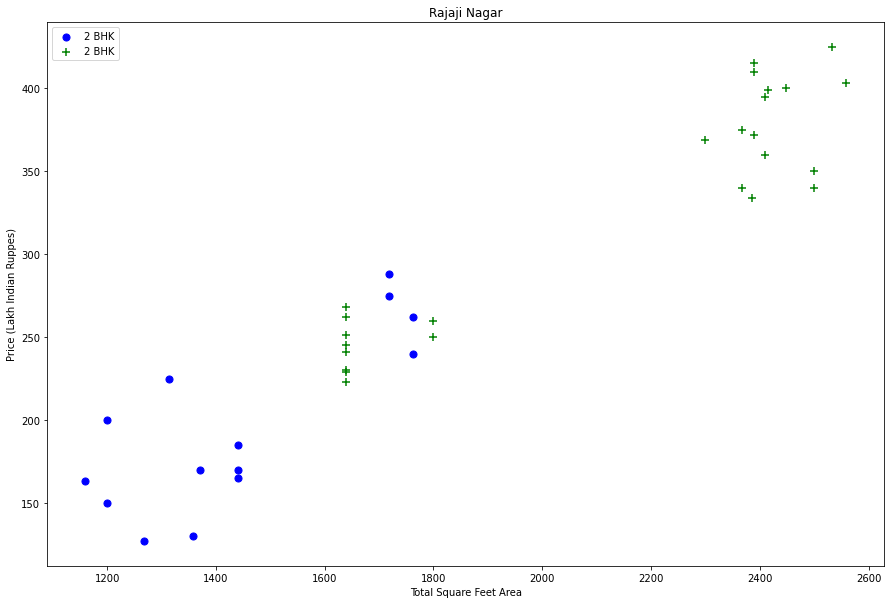

In [50]:
plot_scatter_chart(df8, "Rajaji Nagar")

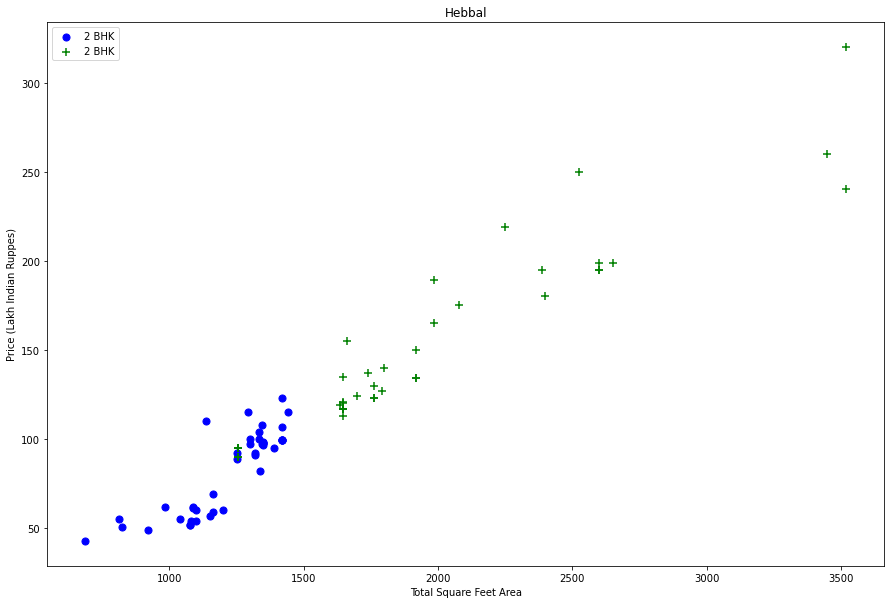

In [51]:
plot_scatter_chart(df8,"Hebbal")

### Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

### Before and after outlier removal: Rajaji Nagar

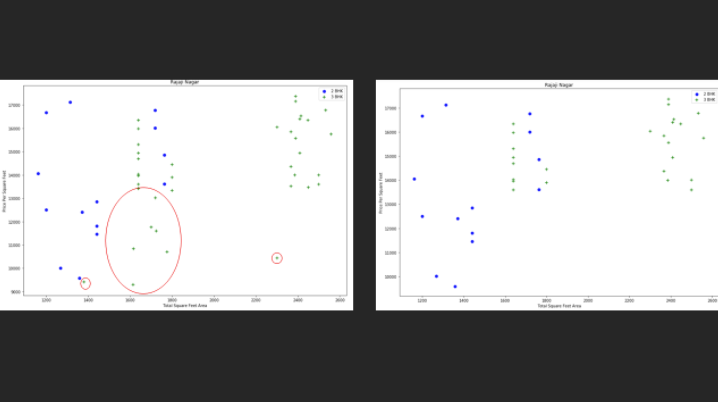

### Before and after outlier removal: Hebbal 

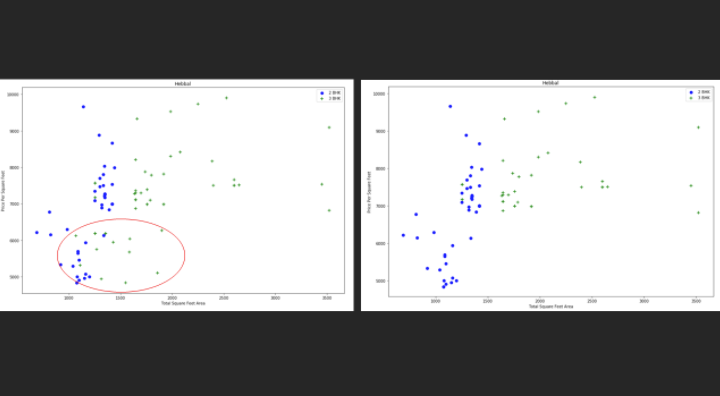

Text(0, 0.5, 'Count')

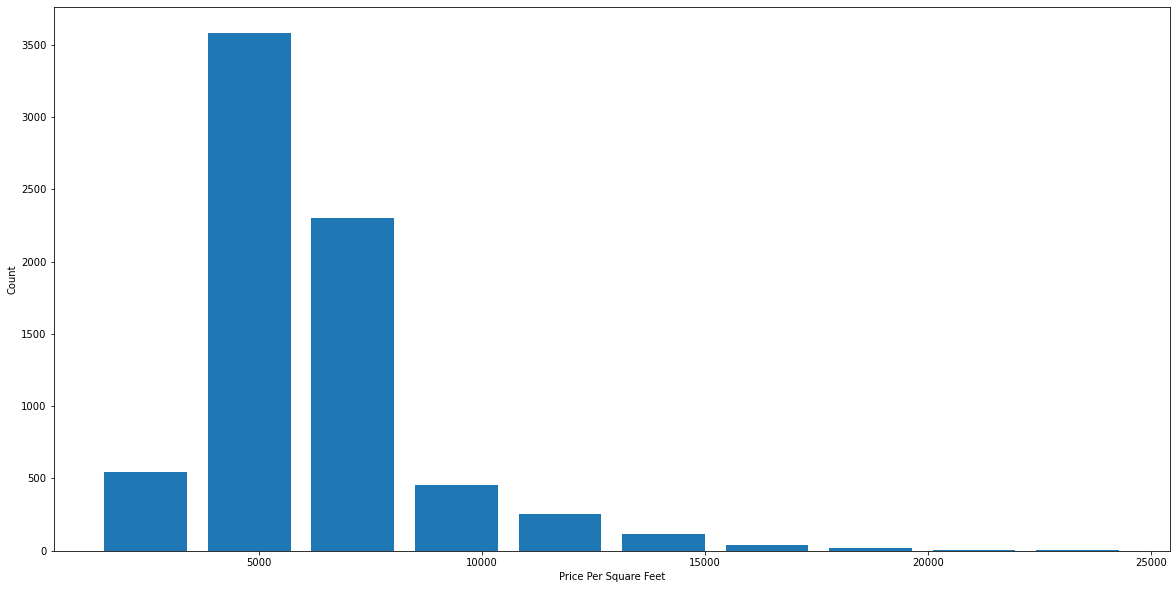

In [52]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft, rwidth = 0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier Removal Using Bathrooms Feature

In [53]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

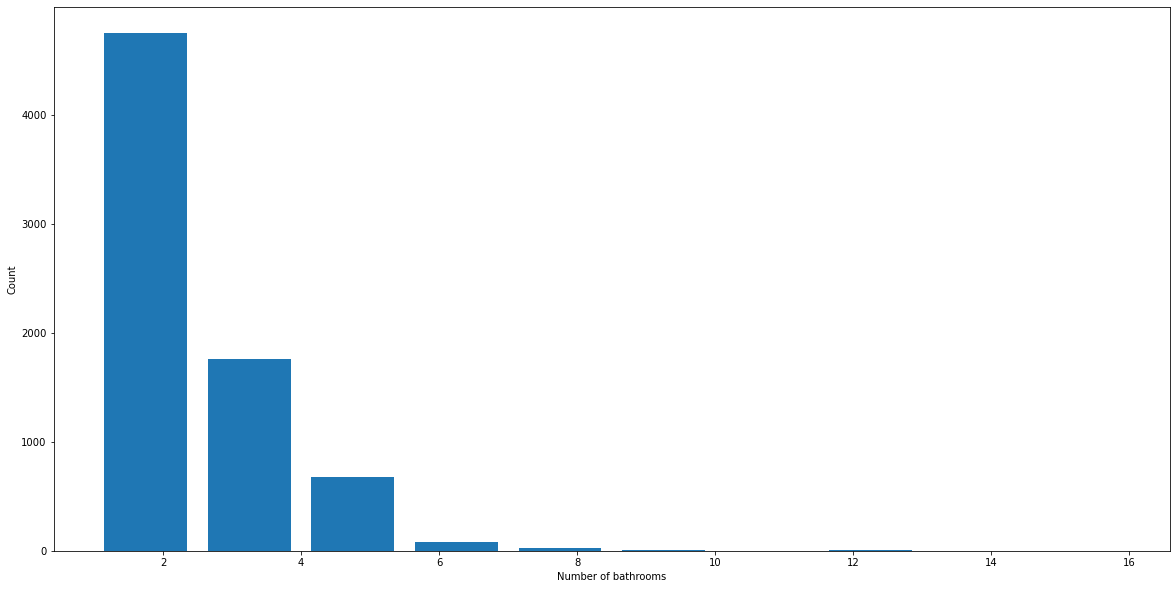

In [54]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [55]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [56]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


### Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [57]:
df9 = df8[df8.bath<df8.bhk+2]

In [58]:
df9.shape

(7239, 7)

In [59]:
import seaborn as sns

In [60]:
df10 = df9.drop(["size","price_per_sqft"], axis = "columns")
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


## Use One Hot Encoding For Location 

In [61]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df11 = pd.concat([df10, dummies.drop("other",axis = "columns")], axis = "columns")
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df12 = df11.drop("location",axis="columns")
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build a Model Now...

In [64]:
X = df12.drop(["price"], axis="columns")
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
y = df12.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [67]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8629132245229486

In [68]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7239 entries, 0 to 10241
Columns: 244 entries, total_sqft to Yeshwanthpur
dtypes: float64(3), int64(1), uint8(240)
memory usage: 1.9 MB


## Use K Fold cross validation to measure accuracy of our LinearRegression model

In [69]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

### We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose 

## Find best model using GridSearchCV

In [70]:
"""algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
print(algos.items())"""

"algos = {\n        'linear_regression' : {\n            'model': LinearRegression(),\n            'params': {\n                'normalize': [True, False]\n            }\n        },\n        'lasso': {\n            'model': Lasso(),\n            'params': {\n                'alpha': [1,2],\n                'selection': ['random', 'cyclic']\n            }\n        },\n        'decision_tree': {\n            'model': DecisionTreeRegressor(),\n            'params': {\n                'criterion' : ['mse','friedman_mse'],\n                'splitter': ['best','random']\n            }\n        }\n    }\nprint(algos.items())"

In [71]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size=0.2, random_state = 0)
    for algo_name, config in algos.items() :
        gs = GridSearchCV(config["model"], config["params"], cv = cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            "model" : algo_name,
            "best_score" : gs.best_score_,
            "best_params" : gs.best_params_
        })
        
    return pd.DataFrame(scores,columns=["model","best_score","best_params"])
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': False}
1,lasso,0.726807,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.750310,"{'criterion': 'mse', 'splitter': 'random'}"


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBRegressor

In [73]:
def compML(df, y, alg) :
    # train test ayrımı
    y = df[y]
    X = df.drop(["price"], axis="columns")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    # modelleme
    model = alg().fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_ismi = alg.__name__
    print(model_ismi,":", score)
    
    

In [74]:
models = [LGBMRegressor,
         XGBRegressor,
         GradientBoostingRegressor,
         RandomForestRegressor,
         DecisionTreeRegressor,
         MLPRegressor,
         KNeighborsRegressor,
         SVR]

In [75]:
for i in models :
    compML(df12, "price", i)

LGBMRegressor : 0.667368843213406
XGBRegressor : 0.7323965424556511
GradientBoostingRegressor : 0.7222741400686549
RandomForestRegressor : 0.7066706385403692
DecisionTreeRegressor : 0.6428319971300394
MLPRegressor : 0.7309596856281114
KNeighborsRegressor : 0.6002096126802824
SVR : 0.4756024165291024


### Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

## Test the model for few properties

In [76]:
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
def predict_price(location, sqft, bath, bhk) :
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0 :
        x[loc_index] = 1
    
    return lr_clf.predict([x])[0]

In [78]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

83.86570258324032

## Export the tested model to a pickle file 

In [79]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)